In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def readColumnsFromFile(filename):
    '''reads in the raw data and returns a list of lists.
    the first list (returned[0]) is the x-coords. '''
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=" ")
        row_array = []
        
        for row in reader:
            row_data = [col.strip() for col in row]          
            row_array.append(row_data)
            
        #converts rows to columns and removes the last item in the columns list which is just spaces
        #this is an atrifact of the file printing system
        #also has zip output in lists not tuples
        col_array = [list(a) for a in zip(*row_array)]
        del col_array[-1]
        #convert list of lists of strings to list of lists of floats
        #return list([[float(j) for j in i] for i in col_array])
        return np.array([[float(j) for j in i] for i in col_array])

In [3]:
def readRowsFromFile(filename):
    '''whereas the other method gets the values in all microhabitats at a certain time in a list, this
    returns the values for the individual microhabitats over all times
    
    first item in the list is the microhab index'''
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=" ")
        row_array = []
        
        for row in reader:
            row_data = [col.strip() for col in row]          
            row_array.append(row_data[:-1])
            
        #converts rows to columns and removes the last item in the columns list which is just spaces
        #this is an atrifact of the file printing system
        #also has zip output in lists not tuples
        #col_array = [list(a) for a in zip(row_array)]
        #print(row_array[-1])
        #del col_array[-1]
        #convert list of lists of strings to list of lists of floats
        #return list([[float(j) for j in i] for i in col_array])
        return np.array([[float(j) for j in i] for i in row_array])
    

In [4]:
def readSingleColumnFromFile(filename):
    '''this method is for reading files which only have one column of numbers in them'''
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=" ")
        data = []
        
        for row in reader:
            data_i = float(row[0])
            data.append(data_i)
            
            
        return data

In [5]:
#global variables
L_500 = 500
alpha_001 = 0.01
max_c_10 = 10.

In [6]:
popSizeOverTime = readSingleColumnFromFile("Tau-testing_phase/pyrithione-testing-pop_size-t=200.0.txt")
biofilmEdgeOverTime = readSingleColumnFromFile("Tau-testing_phase/pyrithione-testing-biofilm_edge-t=100.0.txt")
biofilmSizeOverTime = [max(biofilmEdgeOverTime)- bfe for bfe in biofilmEdgeOverTime]

popDistbOverTime = readColumnsFromFile("Tau-testing_phase/pyrithione-testing-pop_distb-t=200.0.txt")
avgGenoDistbOverTime = readColumnsFromFile("Tau-testing_phase/pyrithione-testing-avgGenoDistb-t=200.0.txt")

avgGenoPerMicrohab = readRowsFromFile("Tau-testing_phase/pyrithione-testing-avgGenoDistb-t=200.0.txt")
genoStDevPerMicroHab = readRowsFromFile("Tau-testing_phase/pyrithione-testing-genoStDevDistb-t=200.0.txt")
popSizePerMicrohab = readRowsFromFile("Tau-testing_phase/pyrithione-testing-pop_distb-t=200.0.txt")

############ - PARALLEL SIMULATION RUNS DATA - #################
popSizeVsTime_para = readSingleColumnFromFile("Tau-parallel-data/pyrithione-testing-pop_size-t=200.0-parallel.txt")
biofilmEdgeVsTime_para = readSingleColumnFromFile("Tau-parallel-data/pyrithione-testing-biofilm_edge-t=200.0-parallel.txt")
biofilmSizeVsTime_para = [max(biofilmEdgeVsTime_para)- bfe for bfe in biofilmEdgeVsTime_para]
popDistbVsTime_para = readColumnsFromFile("Tau-parallel-data/pyrithione-testing-pop_distb-t=200.0-parallel.txt")
avgGenoDistbVsTime_para = readColumnsFromFile("Tau-parallel-data/pyrithione-testing-avgGenoDistb-t=200.0-parallel.txt")
genoStDevVsTime_para = readColumnsFromFile("Tau-parallel-data/pyrithione-testing-genoStDevDistb-t=200.0-parallel.txt")

popSizePerMicrohab_para = readRowsFromFile("Tau-parallel-data/pyrithione-testing-pop_distb-t=200.0-parallel.txt")
avgGenoPerMicrohab_para = readRowsFromFile("Tau-parallel-data/pyrithione-testing-avgGenoDistb-t=200.0-parallel.txt")
genoStDevPerMicrohab_para = readRowsFromFile("Tau-parallel-data/pyrithione-testing-genoStDevDistb-t=200.0-parallel.txt")
#print(len(avgGenoDistbVsTime_para[1:]))

In [7]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

In [8]:
def get_c_vals(alpha, max_c, L):
    
    offset =  (L-1.) - math.log(max_c+1.)/alpha;
    
    c_i = lambda i : max(0., math.exp(alpha*(i-offset))-1.)
    
    cVals = [c_i(i) for i in range(L)]
    
    return cVals

#print(get_c_vals(0.01, 10, 500)[-1])
#print(get_c_vals(0.01, 10, 500)[-240])

In [9]:
def getPopSpeedFromEdgePos(biofilm_edge_loc, duration):
    
    nMeasurements = len(biofilm_edge_loc)
    interval = duration/nMeasurements
    
    timeList = np.arange(0., duration, interval)
    speedList = []
    
    for i in range(1, nMeasurements):
        v = -(biofilm_edge_loc[i] - biofilm_edge_loc[i-1])/interval
        speedList.append(v)
        
    return speedList

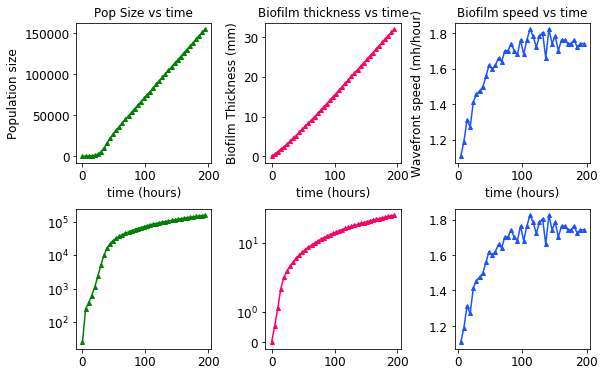

In [17]:
def plotPopSizeAndThicknessOverTime(popSizeList, bioSizeList, bioEdgeList):
    
    duration = 200.
    nMeasurements = len(popSizeList)
    interval = duration/nMeasurements
    
    timeList = np.arange(0., duration, interval)
    thicknessList = [bss*0.1 for bss in bioSizeList]
    speedList = getPopSpeedFromEdgePos(bioEdgeList, duration)
    #print(bioEdgeList)
    
    fig, axarr = plt.subplots(2, 3)
    fig.set_size_inches(9.2, 6)
    fig.subplots_adjust(wspace=0.4, hspace=0.33)
    
    font_size=12
    label_size=12
    axarr[1,0].set_yscale('symlog')
    axarr[1,1].set_yscale('symlog')
    axarr[0,0].plot(timeList, popSizeList, '^-', markersize=4, color='green')
    axarr[0,1].plot(timeList, thicknessList, '^-', markersize=4, color='#ff0066')
    axarr[0,2].plot(timeList[1:], speedList, '^-', markersize=4, color='#1a53ff')
    axarr[1,0].plot(timeList, popSizeList, '^-', markersize=4, color='green')
    axarr[1,1].plot(timeList, thicknessList, '^-', markersize=4, color='#ff0066')
    axarr[1,2].plot(timeList[1:], speedList, '^-', markersize=4, color='#1a53ff')
    
    #axarr[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #axarr[0].yaxis.offsetText.set_fontsize(labelSize)
    axarr[0,0].yaxis.get_offset_text().set_visible(False)
    
    #plt.suptitle("Pop Size over time", fontsize=14)
    axarr[0,0].set_title("Pop Size vs time", fontsize=font_size)
    axarr[0,0].set_ylabel('Population size', fontsize=font_size)
    axarr[0,0].set_xlabel('time (hours)', fontsize=font_size)
    axarr[0,0].tick_params(labelsize=label_size)
    
    axarr[0,1].set_title("Biofilm thickness vs time", fontsize=font_size)
    axarr[0,1].set_xlabel("time (hours)", fontsize=font_size)
    axarr[0,1].set_ylabel("Biofilm Thickness (mm)", fontsize=font_size)
    axarr[0,1].tick_params(labelsize=label_size)
    
    axarr[0,2].set_title("Biofilm speed vs time", fontsize=font_size)
    axarr[0,2].set_xlabel("time (hours)", fontsize=font_size)
    axarr[0,2].set_ylabel("Wavefront speed (mh/hour)", fontsize=font_size)
    
    for ax in axarr.reshape(-1): 
        ax.tick_params(labelsize=label_size)
    
    
    
    plt.savefig('tau_testing_plots/pyrithione-popSize-thickness-popSpeed-vs-t_logScale.pdf', bbox_inches='tight')
    plt.show()

plotPopSizeAndThicknessOverTime(popSizeVsTime_para, biofilmSizeVsTime_para, biofilmEdgeVsTime_para)

In [11]:
def plotBiofilmEdgeOverTime(bioEdgeList, bioSizeList):
    
    duration = 200.
    nMeasurements = len(bioEdgeList)
    interval = duration/nMeasurements
    
    timeList = np.arange(0., duration, interval)
    thicknessList = [bss*0.1 for bss in bioSizeList]
    
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    fig.subplots_adjust(wspace=0.33)
    
    axarr[0].plot(timeList, bioEdgeList, '^-', markersize=4, color='#9900cc')
    axarr[1].plot(timeList, thicknessList, '^-', markersize=4, color='#ff0066')
    
    
    axarr[0].set_title("Biofilm edge over time", fontsize=14)
    axarr[0].set_xlabel("time (hours)", fontsize=14)
    axarr[0].set_ylabel("Edge location", fontsize=14)
    axarr[0].tick_params(labelsize=12)
    
    axarr[1].set_title("Biofilm thickness over time", fontsize=14)
    axarr[1].set_xlabel("time (hours)", fontsize=14)
    axarr[1].set_ylabel("Biofilm Thickness (mm)", fontsize=14)
    axarr[1].tick_params(labelsize=12)
    
    plt.savefig('tau_testing_plots/pyrithione-biofilmEdgeOverTime-testing.pdf', bbox_inches='tight')
    plt.show()
    
#plotBiofilmEdgeOverTime(biofilmEdgeVsTime_para, biofilmSizeVsTime_para)

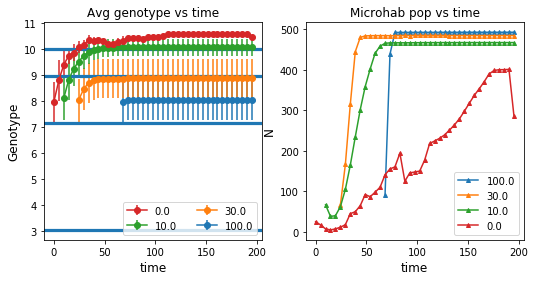

In [16]:
def plotAvgGenoAndStDevOverTime(avgGenoList, stDevList, popSizeArray):
    
    fig, axarr = plt.subplots(1, 2)
    #ax2 = ax.twinx()
    fig.set_size_inches(8.6, 4)
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    duration = 200.
    nMeasurements = len(avgGenoList[0][1:])
    interval = duration/nMeasurements
    timeList = np.arange(0., duration, interval)
    
    cVals = get_c_vals(alpha_001, max_c_10, L_500)
    
    target_mh = 480
    target_mh_list = [-1, -11, -31, -101]
    
    
    for t_mh in target_mh_list[::-1]:
        avgGenoList[t_mh] = zero_to_nan(avgGenoList[t_mh])
        stDevList[t_mh] = zero_to_nan(stDevList[t_mh])
        popSizeArray[t_mh] = zero_to_nan(popSizeArray[t_mh])
        
        axarr[0].axhline(cVals[t_mh], color='#cc33ff', linewidth=3.2)

        
        axarr[0].errorbar(timeList, avgGenoList[t_mh][1:], yerr=stDevList[t_mh][1:], fmt='-o', label=str(499-avgGenoList[t_mh][0]))
        axarr[1].plot(timeList, popSizeArray[t_mh][1:], '^-', markersize=4, label=str(499-avgGenoList[t_mh][0]))
        
    #the [1:] is to avoid plotting the microhab index
    #ax2.plot(timeList, popSizeArray[target_mh][1:], '^-', markersize=4, color='#9900cc')
    #ax.errorbar(timeList, avgGenoList[target_mh][1:], yerr=stDevList[target_mh][1:], fmt='-o', label=str(avgGenoList[target_mh][0]))

    handles, labels = axarr[0].get_legend_handles_labels()
    axarr[0].legend(handles[::-1], labels[::-1],loc='lower right', fontsize=legendsize, ncol=2)
    axarr[1].legend(loc='lower right', fontsize=legendsize, ncol=1)
    
    axarr[0].set_title('Avg genotype vs time', fontsize=titleSize)
    axarr[0].set_xlabel('time', fontsize=labelSize)
    axarr[0].set_ylabel('Genotype', fontsize=labelSize)
    axarr[0].xaxis.set_tick_params(labelsize=numbersize)
    axarr[0].yaxis.set_tick_params(labelsize=numbersize)
    
    axarr[1].set_title('Microhab pop vs time')
    axarr[1].set_xlabel('time', fontsize=labelSize)
    axarr[1].set_ylabel('N', fontsize=labelSize)
    axarr[1].xaxis.set_tick_params(labelsize=numbersize)
    axarr[1].yaxis.set_tick_params(labelsize=numbersize)
    
    #ax.set_ylim(6.5, 11)
    #ax2.set_ylim(-5, 600)
    
    
    plt.savefig('tau_testing_plots/pyrithione-avgGeno_and_N-OverTime.pdf', bbox_inches='tight')
    plt.show()
    
plotAvgGenoAndStDevOverTime(avgGenoPerMicrohab_para, genoStDevPerMicrohab_para, popSizePerMicrohab_para)

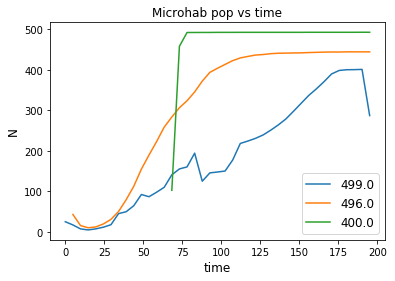

In [13]:
def plotPopSizeOverTime(popSizeArray):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 12
    IDsize=12
    
    duration = 200.
    nMeasurements = len(popSizeArray[0][1:])
    interval = duration/nMeasurements
    timeList = np.arange(0., duration, interval)
    
    target_mh_list = [499, 496, 400]
    
    for t_mh in target_mh_list:
        popSizeArray[t_mh] = zero_to_nan(popSizeArray[t_mh])
        ax.plot(timeList, popSizeArray[t_mh][1:], label=str(popSizeArray[t_mh][0]))
    
    ax.legend(loc='lower right', fontsize=legendsize)
    
    ax.set_title('Microhab pop vs time', fontsize=titleSize)
    ax.set_xlabel('time', fontsize=labelSize)
    ax.set_ylabel('N', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    
    
    plt.savefig('tau_testing_plots/pyrithione-popSizeOverTime.pdf', bbox_inches='tight')
    plt.show()
    
plotPopSizeOverTime(popSizePerMicrohab_para)

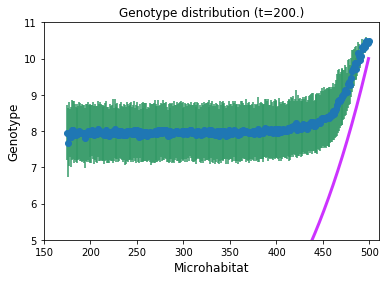

In [49]:
def plotGenoDistbVsX(genoDistb, genoStDevDistb):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 12
    IDsize=12
    microhabs = range(L_500)
    cVals = get_c_vals(alpha_001, max_c_10, L_500)
    
    #max index = 41 at the mo
    time_i_list = [-1]
    #print((genoDistb[1:][0]))
    
    #ax.errorbar(genoDistb[0], genoDistb[1:][2], yerr=genoStDevDistb[1:][2], fmt='-o')
    for t_i in time_i_list:
        genoDistb[t_i] = zero_to_nan(genoDistb[t_i])
        genoStDevDistb[t_i] = zero_to_nan(genoStDevDistb[t_i])
        ax.errorbar(genoDistb[0], genoDistb[1:][t_i], yerr=genoStDevDistb[1:][t_i], fmt='-o', ecolor='#339966')

    ax.plot(microhabs, cVals, linewidth=3, color='#cc33ff')
    ax.set_ylim(5, 11)
    ax.set_xlim(150, 510)
    ax.set_title('Genotype distribution (t=200.)', fontsize=titleSize)
    ax.set_xlabel('Microhabitat', fontsize=labelSize)
    ax.set_ylabel('Genotype', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    #ax.get_xaxis().set_visible(False)
    #ax.set_xticklabels(ax.get_xticks()[::-1])
    plt.savefig('tau_testing_plots/pyrithione-genoDistb-t=200.pdf', bbox_inches='tight')
    plt.show()
    
    
plotGenoDistbVsX(avgGenoDistbVsTime_para, genoStDevVsTime_para)